<center>
<h1> Generating Synthetic Clinical Animal Data using Generative Diffusion Models </h1>
<h2>COMS 4995: Neural Networks and Deep Learning</h2>
<h4>Madhumitha Shridharan (ms6143) & Julia Lewandowski (jtl2189) & Ashwin Somasundaram (as7116)</h4>
<h4>Date: November 15, 2023</h4>
</center>

<h2> Overview </h2>

<h3> Background </h3>
Animal studies are imperative in biosciences to enable the safety of humans. They help with a vast number of areas related to disease prediction, progression, diagnosis and treatment. With the advent of ChatGPT, the popularity of generative models is at an all time high. Generative learning provides an excellent opportunity to reduce the use of animals through models that simulate such experiments. There have been numerous recent approaches to generate synthetic animal data which can substitute actual experiments.

<h3> Related Work </h3>
One popular approach towards this effort includes the introduction of generative adversarial networks (GANs) to simulate animal data. GANs are skilled at reproducing and simulating new data from legacy observations. This recent development has shown promising results amongst real animal data as well. These models provide multi-dimensional information which can be useful for risk assessments of several drugs, and serve new datasets for future trials. Models such as Toxic-GAN have demonstrated the potential of generative adversarial networks in this domain, where a generative model trained on prior data distributions learns to generate realistic data through feedback from an adversarial discriminator model. Toxic-GAN was capable of successfully generating transcriptomic profiles resembling actual gene expression profiles in molecular toxicology studies through this approach [4]. Similarly, the AnimalGAN model generated state-of-the-art results in simulating clinical pathology distributions from large animal populations, predicting rare and harmful events, and ultimately translated preclinical findings into clinical implications without the need for real animal experimentation [5].


<h3> Project Objective </h3>
In our project, we propose to create a diffusion based generative model to tackle the same task of data generation for animal studies, and measure the degree of success in comparison with GANs (e.g. AnimalGAN).

## Data

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
!pip install --upgrade setuptools
!pip install pandas-profiling
!pip install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1) Raw Data: https://dbarchive.biosciencedbc.jp/en/open-tggates/download.html <br>
2) Preprocessed Data from Paper: https://github.com/XC-NCTR/AnimalGAN/tree/main/Data

In order to deeply understand the data used for AnimalGAN, how it was preprocessed, and how the resultant generated data built off of the training data, we begin by examining a subset of their training dataset available through the AnimalGAN repository [here](https://github.com/XC-NCTR/AnimalGAN/tree/main/Data).

### AnimalGAN Data Overview
- 38 clinical pathology measurements.
- 21 hematology and 17 biochemistry data points.
- Main variables were three dose levels (low, middle, and high) and four treatment durations (3, 7, 14, and 28 days).
- Data for model development was derived from experiments with 8078 rats that were treated with 138 compounds under 1649 treatment conditions.

### Example Training Data
- The training data for AnimalGAN was sourced from the Open TG-GATEs database for toxicological research (including in vivo and in vitro samples).
- The data represents exposure to various compounds at different dosages and timepoints.

- **COMPOUND_NAME**: Compound that was administered.
- **SACRI_PERIOD**: Period of time in days that the compound was administered for.
- **DOSE_LEVEL**: Low, middle, or high.
- **RBC (x10^4/ul)**: Red blood cell count per microliter of blood. Since RBCs are important for oxygen transport throughout the body of an animal and removal of carbon dioxide. Changes in this count can be indicative of anemia, dehydration, bone marrow problems, etc.
- **Hb (d/dL)**: Hemoglobin concentration in grams per deciliter. Indicates the blood's oxygen carrying capacity.
- **Ht(%)**: Hematocrit percentage, which is the proportion of the blood volume occupied by red blood cells. High levels can indicate low oxygen, whereas low levels can indicate anemia.
- **MCV (Mean Corpuscular Volume, fL)**: Measures the average size of the red blood cells. Can also be used to classify anemia.
- **MCH (Mean Corpuscular Hemoglobin, pg)**: Average amount of hemoglobin per red blood cell. Can be used to evaluate anemia types.
- **MCHC (Mean Corpuscular Hemoglobin Concentration, %)**: Concentration of hemoglobin in a given volume of packed red blood cells. Useful for assessing the hemoglobin content in RBCs.
- **Ret (Reticulocyte Count, %)**: Percentage of young red blood cells in the blood. High levels can indicate increased red blood cell production, often associated with anemia recovery.
- **Plat (x10^4/uL)**: Platelet count per microliter. Important for blood clotting so abnormal levels can indicate bleeding disorders, bone marrow issues, etc.
- **WBC (x10^2/uL)**: White Blood Cell count per microliter. Indicates body's immune response and can be indicative of infection or inflamation.
- **Neu (%)**: Neutrophil percentage. Type of white blood cell important for protecting body against infections.
- **Eos (%)**: Eosinophil percentage. Type of white blood cell important for inflammatory responses, allergic reactions, etc.
- **Bas (%)**: Basophil percentage. Type of white blood cell that helps in immune system regulation.
- **Mono (%)**: Monocyte percentage. Type of white blood cell that helps in immune system regulation.
- **Lym (%)**: Lymphocyte percentage. Type of white blood cell important for adaptive immune system response.
- **PT (s)**: Prothrombin Time, a measure of blood clotting. Can indicate bleeding disorders or effectiveness of blood-thinning medication.
- **APTT (s)**: Activated Partial Thromboplastin Time. Another measure of blood clotting.
- **Fbg (mg/dL)**: Fibrinogen concentration. Protein essential for blood clot formation.
- **ALP (IU/L)**: Alkaline Phosphatase, an enzyme in the blood related to the liver and live bone. High levels can indicate liver or bone disease.
- **TC (mg/dL)**: Total Cholesterol. High levels indicate higher risk for heart disease.
- **TG (mg/dL)**: Triglycerides, a type of blood fat. High levels indicate higher risk for heart disease.
- **PL (mg/dL)**: Phospholipids, type of lipid used for building cell membranes.
- **TBIL (mg/dL)**: Total Bilirubin, which is a product of red blood cell breakdown. Higher levels can indicate liver problems.
- **DBIL (mg/dL)**: Direct Bilirubin, meaning the portion of the total bilirubin processed directly by the liver. Relevant for detecting any liver diseases or abnormalities.
- **GLC (mg/dL)**: Glucose. Essential for diagnosing and monitoring diabetes.
- **BUN (mg/dL)**: Blood Urea Nitrogen. Indicates how well kidneys are working and body's protein metabolism.
- **CRE (mg/dL)**: Creatinine.
- **Na (meq/L)**: Sodium.
- **K (meq/L)**: Potassium.
- **Cl (meq/L)**: Chloride.
- **Ca (mg/dL)**: Calcium.
- **IP (mg/dL)**: Inorganic Phosphorus.
- **TP (g/dL)**: Total Protein.
- **RALB (g/dL)**: Random Albumin.
- **A/G**: Albumin/Globulin ratio.
- **AST (IU/L)**: Aspartate Aminotransferase, an enzyme in the liver.
- **ALT (IU/L)**: Alanine Aminotransferase, another liver enzyme.
- **LDH (IU/L)**: Lactate Dehydrogenase.
- **GTP (IU/L)**: Gamma-Glutamyl Transpeptidase.

The first column is the compound dosed, the second is the dosage timepoints and the third is the dose level. The remaining 38 columns are the corresponding pathology measurements for the rat administered this treatment.

In [ ]:
ex_train_url = 'https://raw.githubusercontent.com/XC-NCTR/AnimalGAN/main/Data/Example_Data_training.tsv'
ex_train_df = pd.read_csv(ex_train_url, sep='\t')
#ex_train_df = ex_train_df.set_index('COMPOUND_NAME')
ex_train_df.head()

,COMPOUND_NAME,SACRI_PERIOD,DOSE_LEVEL,RBC(x10_4/ul),Hb(g/dL),Ht(%),MCV(fL),MCH(pg),MCHC(%),Ret(%),...,Cl(meq/L),Ca(mg/dL),IP(mg/dL),TP(g/dL),RALB(g/dL),A/G,AST(IU/L),ALT(IU/L),LDH(IU/L),GTP(IU/L)
0,acetaminophen,4 day,Low,595,12.9,37.9,63.7,21.7,34.1,4.8,...,104,10.8,7.8,6.2,3.5,1.3,57,40,72,1
1,acetaminophen,4 day,Low,538,11.6,34.3,63.7,21.5,33.8,8.5,...,106,11.1,7.7,5.7,3.2,1.3,63,30,114,2
2,acetaminophen,4 day,Low,562,12.0,35.7,63.5,21.4,33.7,6.3,...,102,10.9,10.1,6.2,3.8,1.6,60,34,84,3
3,acetaminophen,4 day,Low,615,13.5,40.2,65.4,21.9,33.5,6.9,...,104,10.7,9.3,6.1,3.7,1.5,56,34,83,1
4,acetaminophen,4 day,Low,635,13.1,39.4,62.0,20.5,33.1,6.4,...,105,11.0,10.6,5.9,3.6,1.6,58,33,69,1


In [ ]:
ex_train_df.shape

(589, 41)

The first column is the compound name, and the remaining 1826 columns are the vector of molecular representation for the compound.

In [ ]:
ex_mol_url = 'https://raw.githubusercontent.com/XC-NCTR/AnimalGAN/main/Data/Example_MolecularDescriptors.tsv'
ex_mol_df = pd.read_csv(ex_mol_url, sep='\t')
ex_mol_df = ex_mol_df.set_index('COMPOUND_NAME')
ex_mol_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
COMPOUND_NAME,,,,,,,,,,,,,,,,,,,,,
acarbose,33.790265,26.700638,0,1,55.609056,2.483834,4.967669,55.609056,1.263842,4.703665,...,10.886783,82.039467,645.248013,7.416644,7413,86,234,285,18.722222,9.777778
acetamidofluorene,13.532488,11.112298,0,0,22.184732,2.486542,4.811837,22.184732,1.304984,3.789200,...,9.807472,64.403145,223.099714,7.436657,505,25,92,109,4.916667,3.666667
acetaminophen,8.106344,7.427049,0,0,13.221782,2.219936,4.439872,13.221782,1.201980,3.285958,...,8.795279,40.344003,151.063329,7.553166,166,11,50,53,4.583333,2.500000
acetazolamide,9.826314,9.493560,0,0,14.562939,2.359004,4.584174,14.562939,1.120226,3.466943,...,9.256938,57.567931,221.988132,11.683586,257,14,64,70,6.395833,2.750000
ajmaline,20.164156,15.981222,0,1,32.652758,2.783989,5.365780,32.652758,1.360532,4.204742,...,10.947098,77.909098,326.199428,6.523989,1033,60,156,211,7.145833,4.958333


In [ ]:
ex_mol_df.shape

(12, 1826)

This is the test set. Given compound name, dose timepoints and dose level, we generate the 38 clinical pathology measurements.

In [ ]:
ex_treatment_url = 'https://raw.githubusercontent.com/XC-NCTR/AnimalGAN/main/Data/Example_Treatments_test.tsv'
ex_treatment_df = pd.read_csv(ex_treatment_url, sep='\t')
#ex_treatment_df = ex_treatment_df.set_index('COMPOUND_NAME')
ex_treatment_df.head()

,COMPOUND_NAME,SACRI_PERIOD,DOSE_LEVEL
0,acetamidofluorene,4 day,Low
1,acetamidofluorene,8 day,Low
2,acetamidofluorene,15 day,Low
3,acetamidofluorene,29 day,Low
4,acetamidofluorene,4 day,Middle


### Data Preprocessing

For data preprocessing, we apply the same preprocessing as in AnimalGAN. This is important in order to ensure any differences in performance are a direct result of the different methodology rather than any differences in data preprocessing and manipulation.

#### Training Data
- A MinMaxScaler was used to scale all column values besides the first three (which were categorical) to be between -1 and 1.
- The Time categorical variable was preprocessed using the Time function such that the number of days is normalized by the maximum number of days.
  - 4 day -> 4 / 19
  - 8 day -> 8 / 19
  - 15 day -> 15 / 19
  - 19 day -> 19 / 19
- The Dose categorical variable was preprocessed using the Dose function to map each value to a numerical one.
  - Low -> 0.1
  - Middle -> 0.3
  - High -> 1

#### Molecular Descriptors
- A MinMaxScaler was used to scale all column values to be between -1 and 1.

In [ ]:
# SOURCE: https://github.com/deepsystemspharmacology/AnimalGAN/blob/main/SRC/utils.py
def create_custom_dataloader(data, descriptors, batch_size, device):
    """
    Create a custom DataLoader for data and conditions.

    Args:
        data (DataFrame): DataFrame consisting of input data.
        descriptors (DataFrame): DataFrame of molecular descriptors file.
        batch_size (int): The batch size for the DataLoader.
        shuffle (bool): Whether to shuffle the data during training.

    Returns:
        DataLoader: A DataLoader instance for your data and conditions.
    """
    # Preprocess data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    descriptors = pd.DataFrame(scaler.fit_transform(descriptors), columns=descriptors.columns, index=descriptors.index)
    data = data.iloc[:, 0:3].join(pd.DataFrame(scaler.fit_transform(data.iloc[:, 3:]), columns=data.columns[3:]))
    # Scaled descriptors
    S = pd.DataFrame(columns=descriptors.columns)
    # Measurements
    M = pd.DataFrame(columns=data.columns[3:])
    # Time
    T = []
    # Dose
    D = []
    for i in range(len(data)):
        if data.iloc[i].COMPOUND_NAME in descriptors.index:
            S = pd.concat([S, descriptors[descriptors.index == data.iloc[i].COMPOUND_NAME]], ignore_index=True)
            subset_data = data.iloc[i, 3:].to_frame().T
            M = pd.concat([M, subset_data])
            T.append(Time(data.iloc[i].SACRI_PERIOD))
            D.append(Dose(data.iloc[i].DOSE_LEVEL))

    T = pd.DataFrame(T)
    D = pd.DataFrame(D)

    context_dataset = pd.concat([S,T,D], axis=1)
    measurement_dataset = M
    # Convert data to PyTorch tensors
    S = torch.tensor(S.to_numpy(dtype=np.float32), device=device)
    M = torch.tensor(M.to_numpy(dtype=np.float32), device=device)
    T = scaler.fit_transform(np.array(T, dtype=np.float32).reshape(len(T), -1))
    T = torch.tensor(T, device=device)
    D = scaler.fit_transform(np.array(D, dtype=np.float32).reshape(len(D), -1))
    D = torch.tensor(D, device=device)
    dataset = torch.utils.data.TensorDataset(M, S, T, D)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return  context_dataset, measurement_dataset, dataloader

def Time(SACRIFICE_PERIOD):
    switcher = {
        '4 day': 4 / 29,
        '8 day': 8 / 29,
        '15 day': 15 / 29,
        '29 day': 29 / 29
    }
    return switcher.get(SACRIFICE_PERIOD, 'error')

def Dose(DOSE_LEVEL):
    switcher = {
        'Low': 0.1,
        'Middle': 0.3,
        'High': 1
    }
    return switcher.get(DOSE_LEVEL, 'error')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
context_dataset, measurement_dataset, example_data_dataloader = create_custom_dataloader(ex_train_df, ex_mol_df, 32, device)

In [ ]:
context_dataset

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,0,0
0,-0.744386,-0.656876,-1.0,-1.0,-0.763469,0.032462,0.130486,-0.763469,-0.307653,-0.221182,...,-0.785032,-0.405048,-0.985840,-0.803922,-0.740260,-0.744318,-0.828424,-0.811518,0.137931,0.1
1,-0.744386,-0.656876,-1.0,-1.0,-0.763469,0.032462,0.130486,-0.763469,-0.307653,-0.221182,...,-0.785032,-0.405048,-0.985840,-0.803922,-0.740260,-0.744318,-0.828424,-0.811518,0.137931,0.1
2,-0.744386,-0.656876,-1.0,-1.0,-0.763469,0.032462,0.130486,-0.763469,-0.307653,-0.221182,...,-0.785032,-0.405048,-0.985840,-0.803922,-0.740260,-0.744318,-0.828424,-0.811518,0.137931,0.1
3,-0.744386,-0.656876,-1.0,-1.0,-0.763469,0.032462,0.130486,-0.763469,-0.307653,-0.221182,...,-0.785032,-0.405048,-0.985840,-0.803922,-0.740260,-0.744318,-0.828424,-0.811518,0.137931,0.1
4,-0.744386,-0.656876,-1.0,-1.0,-0.763469,0.032462,0.130486,-0.763469,-0.307653,-0.221182,...,-0.785032,-0.405048,-0.985840,-0.803922,-0.740260,-0.744318,-0.828424,-0.811518,0.137931,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,-0.229409,-0.079883,-1.0,1.0,-0.238188,1.000000,1.000000,-0.238188,1.000000,0.412035,...,-0.380302,-0.755144,-0.907144,0.156863,-0.051948,0.153409,-0.617386,-0.440838,1.000000,1.0
585,-0.229409,-0.079883,-1.0,1.0,-0.238188,1.000000,1.000000,-0.238188,1.000000,0.412035,...,-0.380302,-0.755144,-0.907144,0.156863,-0.051948,0.153409,-0.617386,-0.440838,1.000000,1.0
586,-0.229409,-0.079883,-1.0,1.0,-0.238188,1.000000,1.000000,-0.238188,1.000000,0.412035,...,-0.380302,-0.755144,-0.907144,0.156863,-0.051948,0.153409,-0.617386,-0.440838,1.000000,1.0
587,-0.229409,-0.079883,-1.0,1.0,-0.238188,1.000000,1.000000,-0.238188,1.000000,0.412035,...,-0.380302,-0.755144,-0.907144,0.156863,-0.051948,0.153409,-0.617386,-0.440838,1.000000,1.0


In [ ]:
measurement_dataset

,RBC(x10_4/ul),Hb(g/dL),Ht(%),MCV(fL),MCH(pg),MCHC(%),Ret(%),Plat(x10_4/uL),WBC(x10_2/uL),Neu(%),...,Cl(meq/L),Ca(mg/dL),IP(mg/dL),TP(g/dL),RALB(g/dL),A/G,AST(IU/L),ALT(IU/L),LDH(IU/L),GTP(IU/L)
0,0.252264,0.475862,0.457944,0.446809,0.45098,0.0,-0.127273,-0.18888,-0.584034,-0.28,...,-0.428571,-0.090909,-0.252747,0.133333,0.166667,-0.181818,-0.984694,-0.876333,-0.985754,-0.75
1,0.104787,0.296552,0.28972,0.446809,0.372549,-0.103448,0.545455,-0.117289,-0.936508,0.08,...,-0.238095,0.045455,-0.274725,-0.2,-0.083333,-0.181818,-0.978571,-0.918977,-0.970009,-0.5
2,0.166882,0.351724,0.35514,0.425532,0.333333,-0.137931,0.145455,-0.169078,-0.807656,-0.2,...,-0.619048,-0.045455,0.252747,0.133333,0.416667,0.090909,-0.981633,-0.901919,-0.981256,-0.25
3,0.30401,0.558621,0.565421,0.62766,0.529412,-0.206897,0.254545,-0.115004,-0.956116,-0.48,...,-0.428571,-0.136364,0.076923,0.066667,0.333333,-0.0,-0.985714,-0.901919,-0.981631,-0.75
4,0.355757,0.503448,0.528037,0.265957,-0.019608,-0.344828,0.163636,-0.063214,-0.793651,-0.08,...,-0.333333,0.0,0.362637,-0.066667,0.25,0.090909,-0.983673,-0.906183,-0.986879,-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0.658473,0.737931,0.691589,-0.265957,-0.372549,0.103448,-0.381818,0.134044,-0.232493,-0.56,...,-0.52381,-0.090909,-0.230769,0.2,0.5,0.090909,-0.981633,-0.889126,-0.986504,-0.5
585,0.772316,0.834483,0.803738,-0.276596,-0.45098,0.0,-0.454545,0.040366,-0.106443,-0.68,...,-0.52381,-0.227273,-0.494505,-0.066667,0.5,0.454545,-0.981633,-0.863539,-0.986129,-0.75
586,0.567917,0.710345,0.728972,0.148936,-0.058824,-0.241379,-0.490909,0.026657,-0.204482,-0.36,...,-0.619048,0.045455,-0.450549,0.133333,0.333333,-0.0,-0.981633,-0.906183,-0.980131,-0.5
587,0.857697,0.958621,0.985981,-0.021277,-0.294118,-0.241379,-0.527273,0.109673,-0.437908,-0.36,...,-0.428571,0.181818,-0.450549,0.2,0.75,0.454545,-0.981633,-0.876333,-0.988754,-0.75


# Simple Conditional Diffusion Model

In [ ]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.data import DataLoader

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")
device = 'cuda'

## Diffusion Model

In [ ]:
class NoisePrediction(nn.Module):
  # same architecture as generator in paper
  def __init__(self, sample_size = 38, context_size = 1828):
    super(NoisePrediction, self).__init__()
    self.input_size = sample_size+context_size
    self.model = nn.Sequential(
            nn.Linear(sample_size + context_size, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 1024),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 64),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 38),
        )

  def forward(self, sample, time, context):
      # Concatenate conditions and sample to produce input
      input = torch.cat((sample, context), -1)

      predicted_noise = self.model(input)

      return predicted_noise

In [ ]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, sample_size=38, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.sample_size = sample_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_sample(self, x, t):

        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:,None].expand(-1, x.shape[1])

        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:,None].expand(-1, x.shape[1])

        eps = torch.randn_like(x)

        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, contexts, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.sample_size)).double().to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).to(self.device)
                predicted_noise = model(x, t, contexts)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)


                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t]
                alpha_hat = self.alpha_hat[t]
                beta = self.beta[t]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise



        model.train()
        #x = (x.clamp(-1, 1) + 1) / 2
        #x = (x * 255).type(torch.uint8)
        return x


## Training

In [ ]:
def train(diffusion, model, dataloader, epochs=300, sample_size=38,s_size = 1826, d_size=1, t_size=1, lr=3e-4):

  # set up optimizer
  optimizer = optim.AdamW(model.parameters(), lr=lr)
  mse = nn.MSELoss()

  # batch on which training loss is evaluated
  M_train,S_train,T_train,D_train = next(iter(dataloader))

  t_train = diffusion.sample_timesteps(M_train.shape[0]).to('cuda')
  x_t_train, noise_train = diffusion.noise_sample(M_train, t_train)

  contexts_train = torch.cat((S_train,T_train,D_train),dim=1)

  def train_loss():
    predicted_noise_train = model(x_t_train, t_train, contexts_train)
    train_loss = mse(noise_train, predicted_noise_train)

    return train_loss

  context_size = s_size+d_size+t_size

  losses = []
  for epoch in range(epochs):

      for M,S,T,D in dataloader:

          t = diffusion.sample_timesteps(M.shape[0]).to('cuda')
          x_t, noise = diffusion.noise_sample(M, t)
          if np.random.random() < 0.1:

            contexts = torch.zeros((x_t.shape[0],context_size)).to('cuda')

          else:

            contexts = torch.cat((S,T,D),dim=1)


          predicted_noise = model(x_t, t, contexts)
          loss = mse(noise, predicted_noise)

          losses.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      if epoch % 10 == 0:

        plt.plot(losses)
        plt.yscale('log')
        plt.ylabel('loss')
        plt.show()

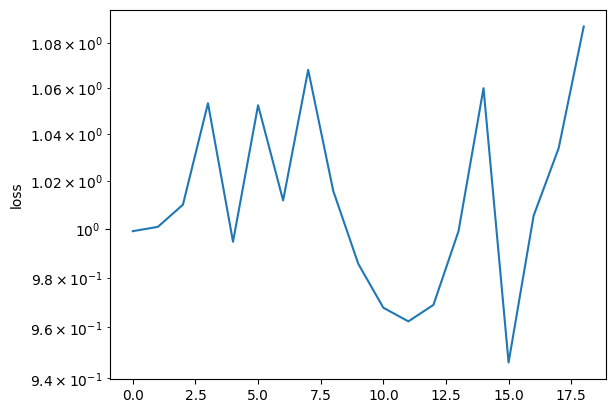

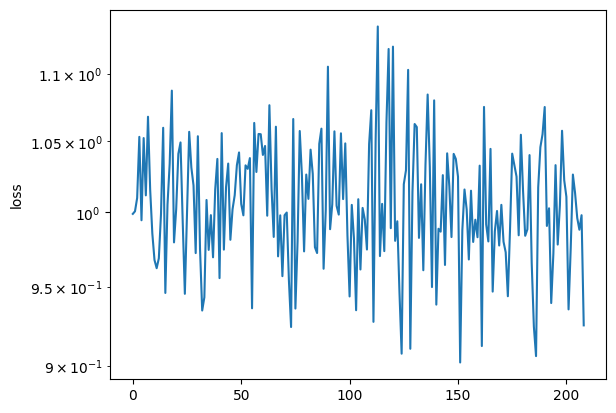

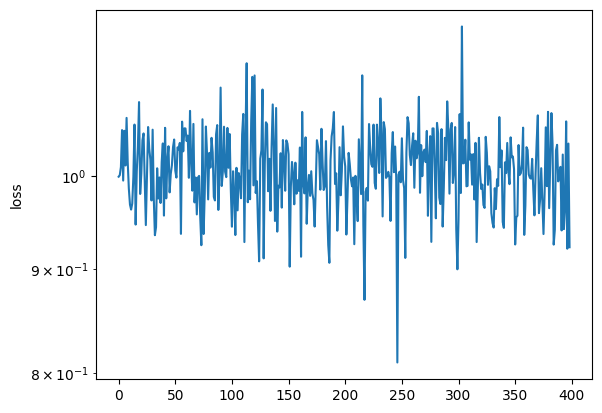

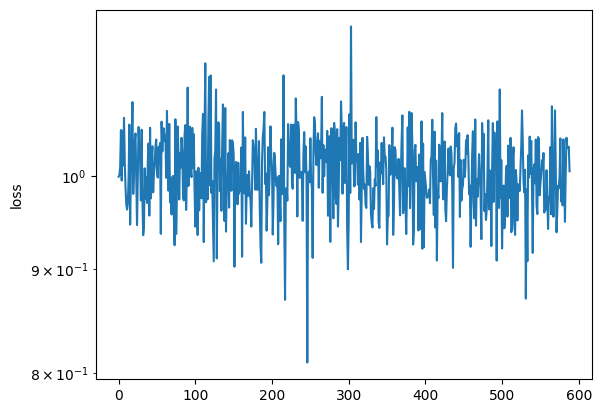

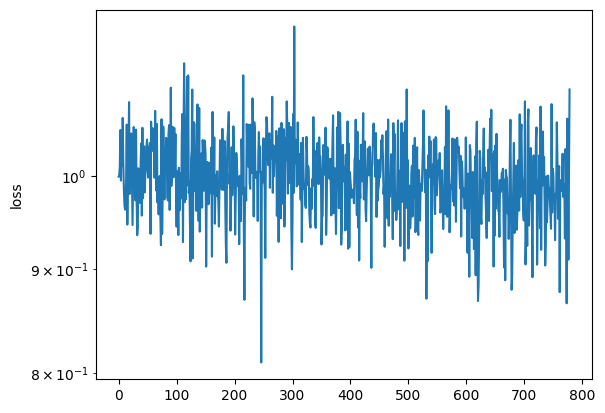

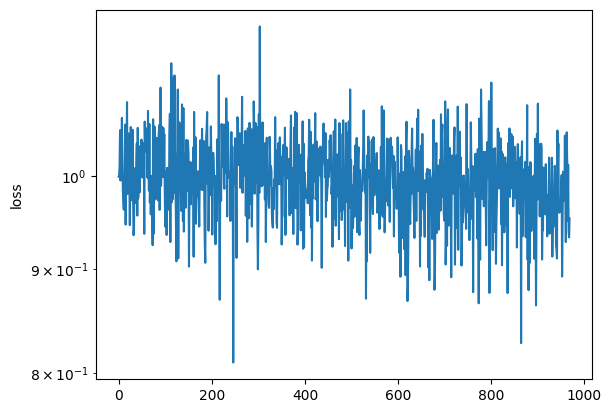

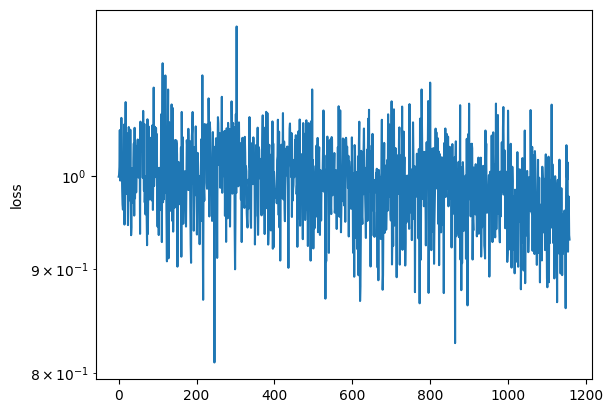

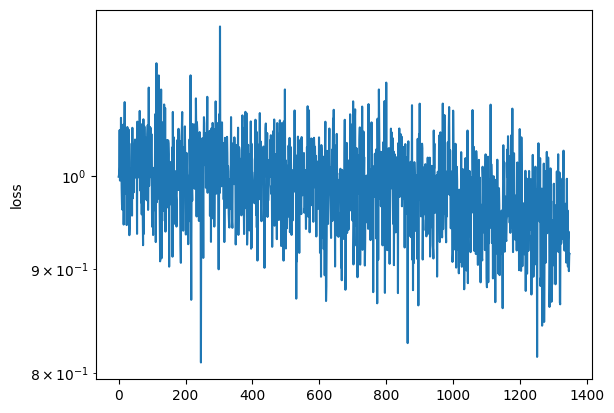

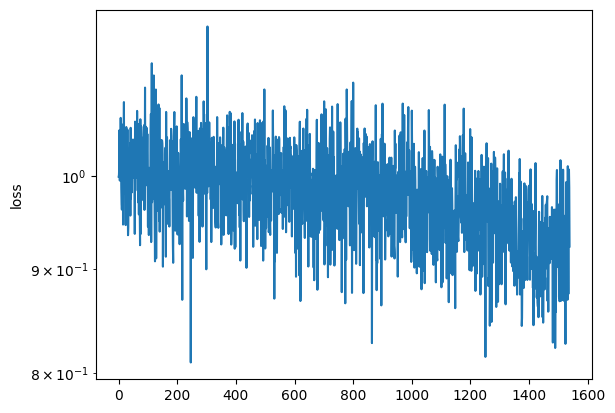

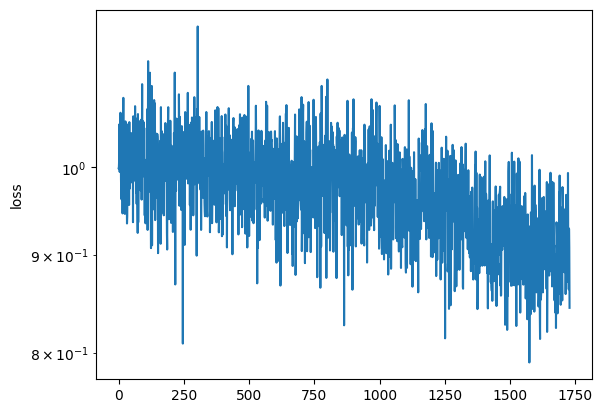

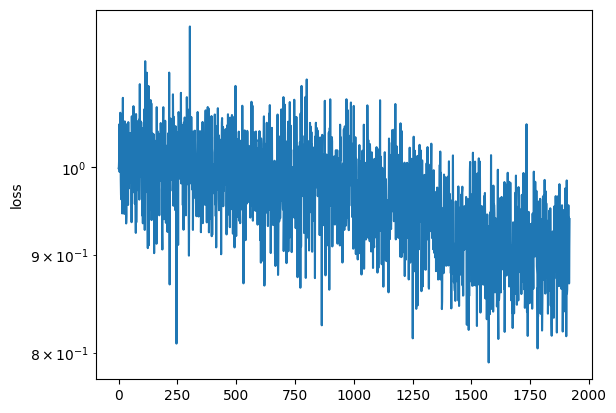

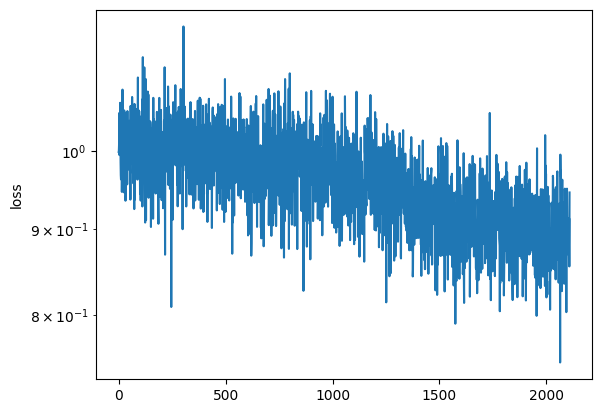

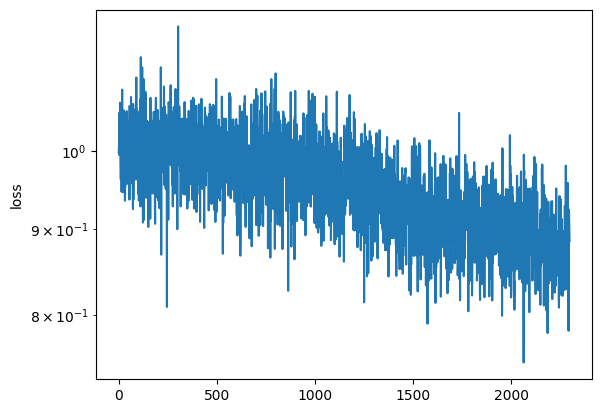

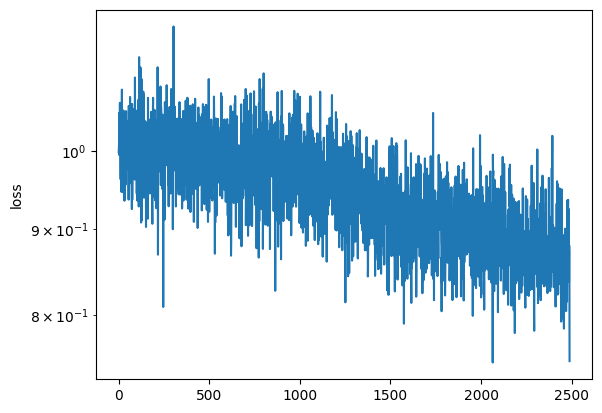

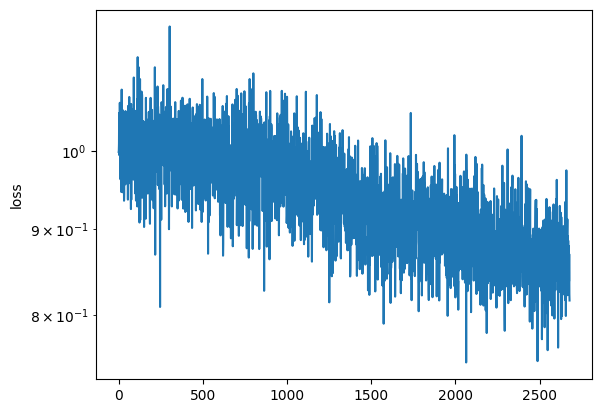

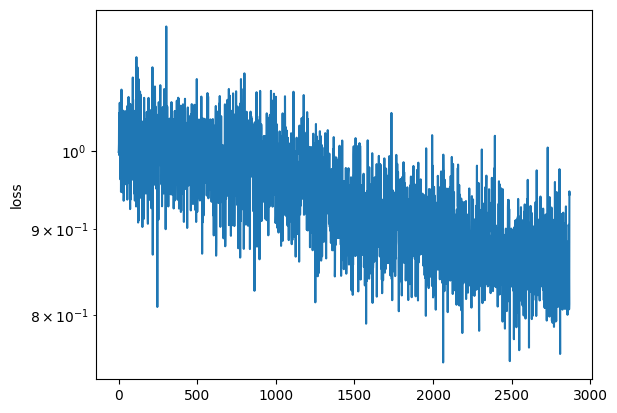

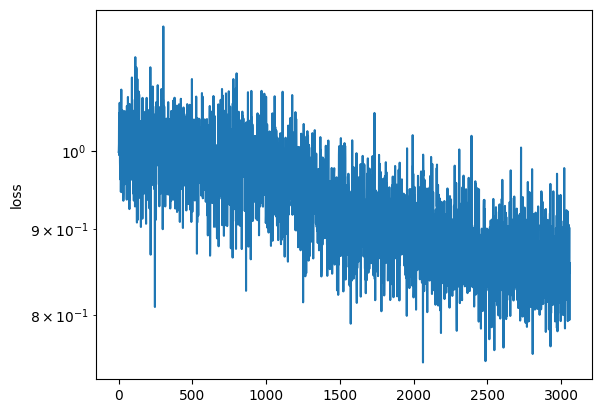

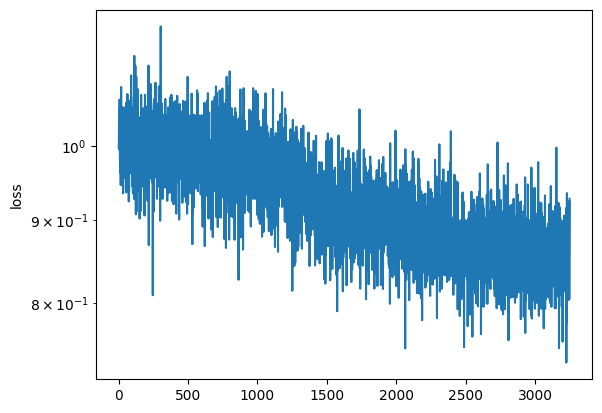

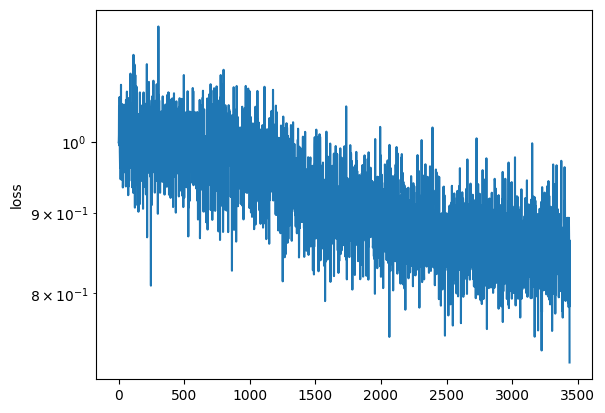

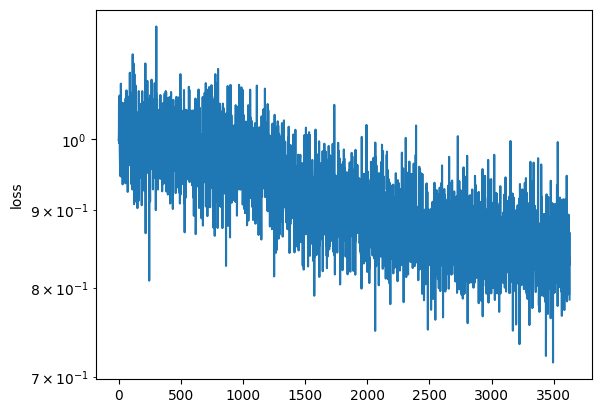

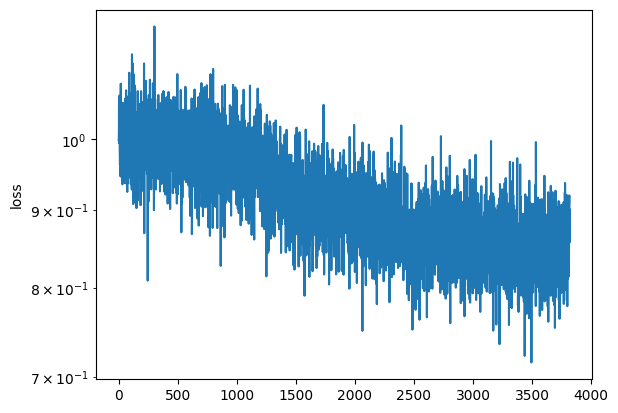

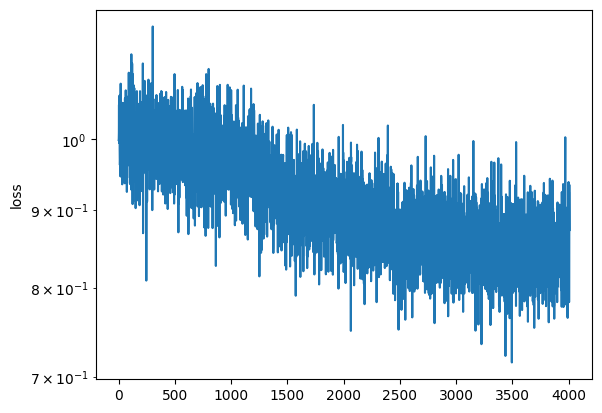

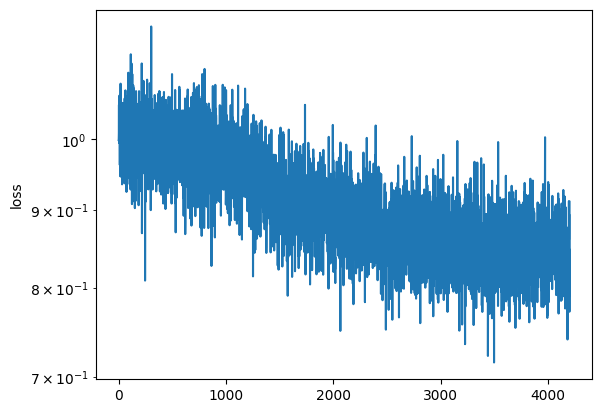

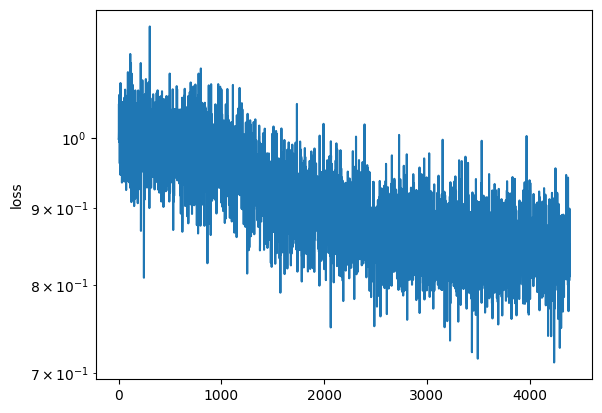

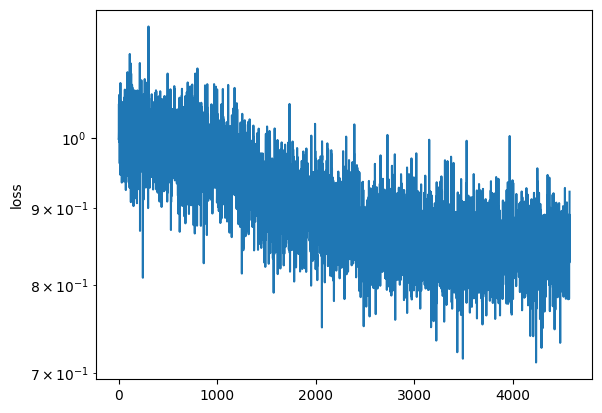

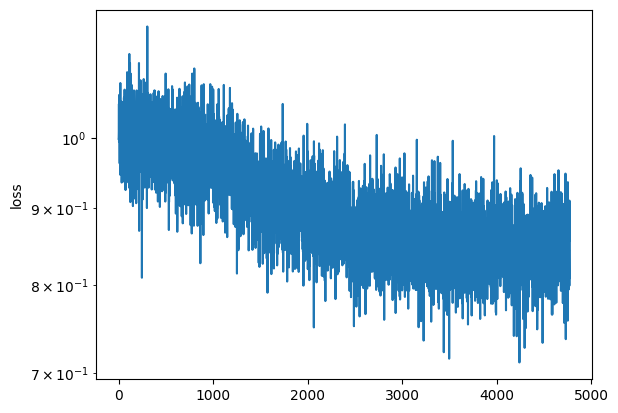

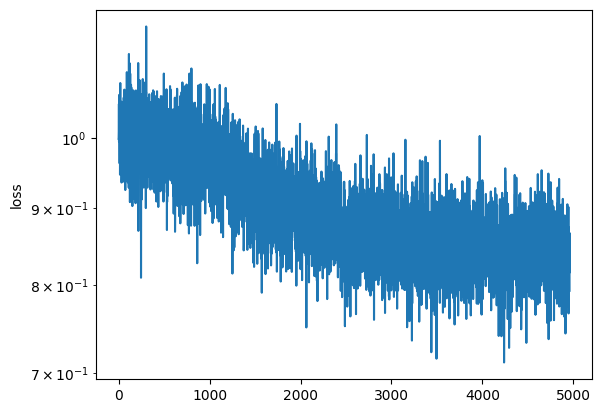

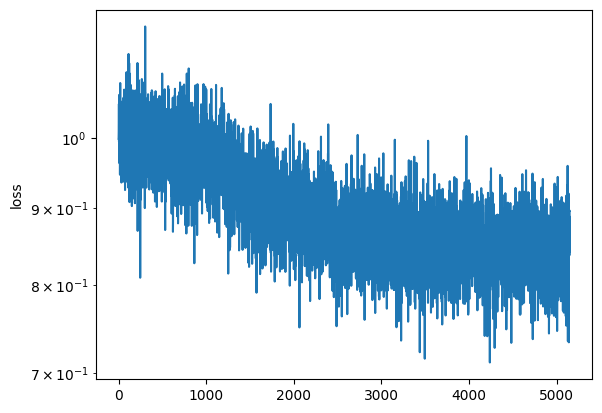

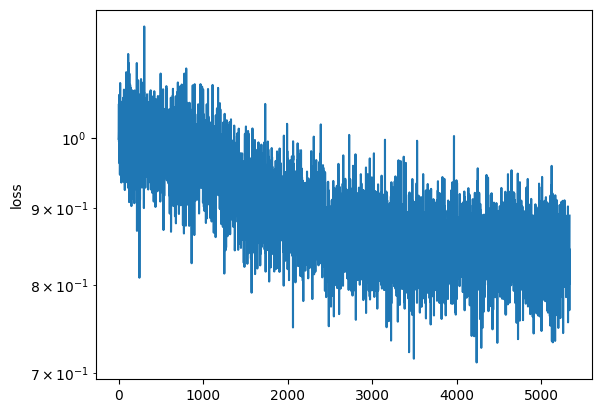

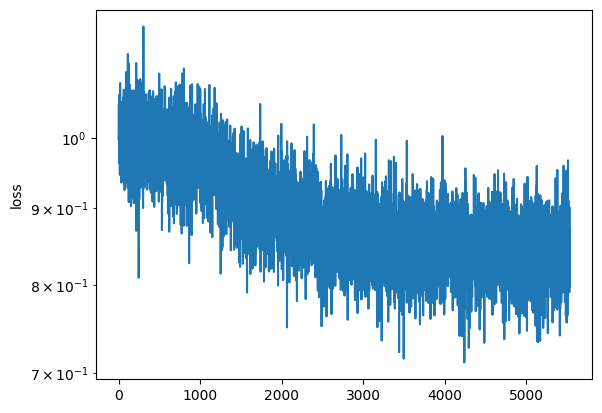

In [ ]:
model = NoisePrediction().to(device)
diffusion = Diffusion(device='cuda')
train(diffusion, model, example_data_dataloader)

In [ ]:
len(context_dataset)

589

In [ ]:
for i in range(len(context_dataset)):
  context = context_dataset.iloc[i,:]
  context = torch.tensor(np.array(context), device='cuda').unsqueeze(0)

  generated_samples = diffusion.sample(model, 1, context, cfg_scale=0)
  print(torch.cat([context]*generated_samples, dim=0))


NameError: ignored

#Implementation of the AnimalGAN Model

Progress so far on the GANS model: We were able to dig deep into the design and implementation of the AnimalGAN model stated in the paper. We decided that we will be implementing and testing it in order to compare the performance with our diffusion based model. Below, the Generator and Discriminator Class have been derived from the source material in the research paper. The training function is also included. The Generator will be trained intermittently along with the Discriminator just like in a regular GANS model. The next step is to run the model against our data and compare results, to hopefully encounter some failure modes where improvements with diffusion can be identified.

In [ ]:
animalgan_train_path = 'https://raw.githubusercontent.com/JTL-lab/AnimalDiffusion/main/data/AnimalGAN-Data/train_data.tsv?token=GHSAT0AAAAAACLSWPZ4A6D62R3DFWH3K5L6ZL2NNVA'
animalgan_moldes_path = 'https://raw.githubusercontent.com/JTL-lab/AnimalDiffusion/main/data/AnimalGAN-Data/MolecularDescriptors.tsv?token=GHSAT0AAAAAACLSWPZ4UPJTVGBRNJZPJ5SKZL2NOHQ'

In [ ]:
!ls /content/drive/MyDrive/AnimalGAN-Data/

 AnimalGAN-Data   AnimalGAN-Data-20231213T213751Z-001.zip  'Colab Notebooks'


In [ ]:
animalgan_train_df = pd.read_csv(animalgan_train_path,sep='\t')
animalgan_mol_df = pd.read_csv(animalgan_moldes_path,sep='\t')
animalgan_mol_df = animalgan_mol_df.set_index('COMPOUND_NAME')

In [ ]:
animalgan_train_df[['COMPOUND_NAME','SACRI_PERIOD','DOSE_LEVEL']]

,COMPOUND_NAME,SACRI_PERIOD,DOSE_LEVEL
0,thioacetamide,29 day,Middle
1,lomustine,29 day,Low
2,nicotinic acid,29 day,Middle
3,metformin,8 day,High
4,perhexiline,15 day,Low
...,...,...,...
5118,colchicine,15 day,Low
5119,adapin,8 day,High
5120,methapyrilene,8 day,Low
5121,dantrolene,8 day,High


In [ ]:
animalgan_mol_df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
COMPOUND_NAME,,,,,,,,,,,,,,,,,,,,,
nicotinic acid,6.542301,6.236096,1,0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,8.590258,37.289972,123.032028,8.788002,88,9,40.0,43.0,3.472222,2.111111
disulfiram,10.744501,11.044544,0,0,18.877841,2.210509,4.421017,18.877841,1.179865,3.607722,...,9.049115,46.690407,296.050933,8.223637,502,21,66.0,72.0,7.944444,4.138889
acetaminophen,8.106344,7.427049,0,0,13.221782,2.219936,4.439872,13.221782,1.201980,3.285958,...,8.795279,40.344003,151.063329,7.553166,166,11,50.0,53.0,4.583333,2.500000
isoniazid,7.140017,6.873356,0,0,12.857279,2.214320,4.428639,12.857279,1.285728,3.188884,...,8.703009,38.792641,137.058912,8.062289,121,11,44.0,48.0,3.722222,2.444444
carbon tetrachloride,3.464102,3.464102,0,0,4.000000,2.000000,4.000000,4.000000,0.800000,2.444466,...,7.625107,29.418928,151.875411,30.375082,16,0,20.0,16.0,4.062500,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
acetazolamide,9.826314,9.493560,0,0,14.562939,2.359004,4.584174,14.562939,1.120226,3.466943,...,9.256938,57.567931,221.988132,11.683586,257,14,64.0,70.0,6.395833,2.750000
fluphenazine,23.587910,17.129344,0,2,38.805135,2.501762,5.003525,38.805135,1.293504,4.335906,...,10.405383,65.948743,437.174868,7.806694,2618,49,160.0,188.0,9.201389,6.527778
cimetidine,12.089765,11.136291,0,3,21.154703,2.257483,4.368546,21.154703,1.244394,3.701955,...,9.034200,61.513019,252.115716,7.639870,664,18,74.0,80.0,6.083333,4.194444


In [ ]:
#Source:https://github.com/XC-NCTR/AnimalGAN/blob/main/SRC/model.py
class Generator(nn.Module):
    def __init__(self, Z_dim, Stru_dim, Time_dim, Dose_dim, Measurement_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            *block(Z_dim + Stru_dim + Time_dim + Dose_dim, 4096, normalize=False),
            *block(4096, 2048),
            *block(2048, 1024),
            *block(1024, 256),
            *block(256, 64),
            nn.Linear(64, Measurement_dim),
            nn.Tanh()
        )

    def forward(self, noise, Stru, Time, Dose):
        # Concatenate conditions and noise to produce input
        gen_input = torch.cat([noise, Stru, Time, Dose], -1)
        Measurement = self.model(gen_input)
        return Measurement


class Discriminator(nn.Module):
    def __init__(self, Stru_dim, Time_dim, Dose_dim, Measurement_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(Stru_dim + Time_dim + Dose_dim + Measurement_dim, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 1024),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 64),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
        )

    def forward(self, Measurement, Stru, Time, Dose):
        # Concatenate conditions and real_Measurement to produce input
        d_in = torch.cat((Measurement, Stru, Time, Dose), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, Stru, Time, Dose, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates, Stru, Time, Dose)
    fake = torch.ones(real_samples.shape[0], 1).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def calc_generator_regularization(Stru, Time, Dose, z, device, generator):
    b_sz = Stru.shape[0]
    Stru1 = Stru
    Time1 = Time
    Dose1 = Dose
    idx=torch.randperm(b_sz)
    Stru2 = Stru[idx]
    Time2 = Time[idx]
    Dose2 = Dose[idx]

    # Sample random numbers epsilon
    epsilon = torch.rand(b_sz, 1, device=device)

    interpolated_Stru = epsilon*Stru1 + (1 - epsilon)*Stru2
    interpolated_Time = epsilon*Time1 + (1 - epsilon)*Time2
    interpolated_Dose = epsilon*Dose1 + (1 - epsilon)*Dose2

    #conditions1 = torch.cat([Stru1, Time1, Dose1], -1)
    #conditions2 = torch.cat([Stru2, Time2, Dose2], -1)
    #interpolated_conditions = epsilon * conditions1 + (1 - epsilon) * conditions2

    perturbation_std = 0.01
    # perturbations = torch.randn(b_sz, interpolated_conditions.shape[0])*perturbation_std
    # perturbated_conditions = interpolated_conditions + perturbations
    perturbated_Stru = interpolated_Stru + torch.randn(b_sz, interpolated_Stru.shape[1]).to(device) * perturbation_std
    perturbated_Time = interpolated_Time + torch.randn(b_sz, interpolated_Time.shape[1]).to(device) * perturbation_std
    perturbated_Dose = interpolated_Dose + torch.randn(b_sz, interpolated_Dose.shape[1]).to(device) * perturbation_std

    batch_interpolated_samples = generator(z.detach(), interpolated_Stru.detach(), interpolated_Time.detach(), interpolated_Dose.detach())
    batch_noise_samples = generator(z.detach(), perturbated_Stru.detach(), perturbated_Time.detach(), perturbated_Dose.detach())
    gp_loss = torch.nn.MSELoss()
    gp = gp_loss(batch_interpolated_samples, batch_noise_samples)
    return gp

def train(generator, discriminator, dataloader, n_epochs, n_critic, Z_dim, device, lr, b1, b2, interval, model_path,
          lambda_gp, lambda_GR):
    '''
    :param lambda_gp: Loss weight for gradient penalty
    '''

    # Define optimizers for generator and discriminator
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    # Training loop
    for epoch in range(n_epochs):
        for i, (Measurement, Stru, Time, Dose) in enumerate(dataloader):
            batch_size = Measurement.shape[0]

            #  Train Discriminator
            optimizer_D.zero_grad()
            # Sample noise
            z = torch.randn(batch_size, Z_dim).to(device)
            z = (z - z.min()) / (z.max() - z.min())
            z = 2 * z - 1
            gen_Measurement = generator(z, Stru, Time, Dose)
            validity_real = discriminator(Measurement, Stru, Time, Dose)
            validity_fake = discriminator(gen_Measurement.detach(), Stru, Time, Dose)

            # Compute the Wasserstein loss and gradient penalty for the discriminator
            gradient_penalty = compute_gradient_penalty(discriminator, Measurement, gen_Measurement, Stru, Time, Dose,
                                                        device)
            # Backpropagate and optimize the discriminator
            d_loss = -torch.mean(validity_real) + torch.mean(validity_fake) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            # Train the generator every n_critic steps
            if (epoch * len(dataloader) + i) % n_critic == 0:
                gen_Measurement = generator(z, Stru, Time, Dose)
                validity = discriminator(gen_Measurement, Stru, Time, Dose)

                # Compute the Regularization term for genenerator LGR(G)
                LGR = lambda_GR * calc_generator_regularization(Stru, Time, Dose, z, device, generator)
                # Generator loss
                g_loss = -torch.mean(validity) + LGR

                # Update generator
                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch + 1, 1000, i + 1, len(dataloader), d_loss.item(), g_loss.item())
            )
        if (epoch + 1) % interval == 120:
            if not os.path.exists(model_path):
                os.makedirs(model_path)
            torch.save(generator.state_dict(), os.path.join(model_path, 'generator_{}'.format(epoch + 1)))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(1828, 1826, 1, 1, 38).to(device)
discriminator = Discriminator(1826, 1, 1, 38).to(device)

context_dataset, measurement_dataset, dataloader = create_custom_dataloader(animalgan_train_df, animalgan_mol_df, 32, device)
    # Training
train(generator, discriminator, dataloader, 1000, 5, 1828, device, 1e-7,
      0.8, 0.95, 500, './', 1.0, 0.2)

Streaming output truncated to the last 5000 lines.
[Epoch 969/1000] [Batch 153/161] [D loss: -7.155943] [G loss: -4.415560]
[Epoch 969/1000] [Batch 154/161] [D loss: -8.014643] [G loss: -4.415560]
[Epoch 969/1000] [Batch 155/161] [D loss: -6.988440] [G loss: -4.415560]
[Epoch 969/1000] [Batch 156/161] [D loss: -5.410325] [G loss: -4.415560]
[Epoch 969/1000] [Batch 157/161] [D loss: -5.869688] [G loss: -4.415560]
[Epoch 969/1000] [Batch 158/161] [D loss: -6.758544] [G loss: -2.103785]
[Epoch 969/1000] [Batch 159/161] [D loss: -8.667776] [G loss: -2.103785]
[Epoch 969/1000] [Batch 160/161] [D loss: -4.950167] [G loss: -2.103785]
[Epoch 969/1000] [Batch 161/161] [D loss: -5.972293] [G loss: -2.103785]
[Epoch 970/1000] [Batch 1/161] [D loss: -5.654299] [G loss: -2.103785]
[Epoch 970/1000] [Batch 2/161] [D loss: -9.926384] [G loss: -3.328135]
[Epoch 970/1000] [Batch 3/161] [D loss: -9.288298] [G loss: -3.328135]
[Epoch 970/1000] [Batch 4/161] [D loss: -3.296180] [G loss: -3.328135]
[Epoch 9

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(1828, 1826, 1, 1, 38).to(device)
weights = torch.load('./animalgangenerator')
generator.load_state_dict(weights)
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=3656, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): BatchNorm1d(2048, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=2048, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=1024, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=256, out_features=64, bias=True)
    (12): BatchNorm1d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Linear(in_features

In [ ]:
torch.save(generator.state_dict(), os.path.join('./', 'animalgangenerator'))

In [ ]:
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
def generate(treatments, descriptors, training_data, descriptors_training, result_path, generator, device):
    '''
    Args:
    treatments (pd.DataFrame): treatment conditions of interest
    discriptors (pd.DataFrame): molecular descriptors of the compounds of interest
    training_data (pd.DataFrame): all the training data used for the pretrained model
    descriptors_training (pd.DataFrame): molecular descriptors of the compounds used to train the model
    result_path (str) : path to the file where you want to store the results
    '''

    scaler = MinMaxScaler(feature_range=(-1, 1))

    scaler.fit(descriptors_training)
    scaled_MDs = pd.DataFrame(scaler.transform(descriptors), columns=descriptors.columns, index=descriptors.index)
    print(len(treatments))
    S = pd.DataFrame()
    count = 0
    for i in range(len(treatments)):
        #if treatments.iloc[i].COMPOUND_NAME == 'penicillamine':
          #print('Exists',i)

        if treatments.iloc[i].COMPOUND_NAME not in scaled_MDs.index:
          #print(treatments.iloc[i].COMPOUND_NAME)
          count+=1
          #print(scaled_MDs[scaled_MDs.index == treatments.iloc[i].COMPOUND_NAME])
        S = pd.concat([S, scaled_MDs[scaled_MDs.index == treatments.iloc[i].COMPOUND_NAME]])
    #print('count:',count)
    #print(S.shape)
    S = torch.tensor(S.to_numpy(dtype=np.float32), device=device)

    scaler.fit(training_data['SACRI_PERIOD'].apply(Time).to_numpy(dtype=np.float32).reshape(-1, 1))
    T = scaler.transform(treatments['SACRI_PERIOD'].apply(Time).to_numpy(dtype=np.float32).reshape(-1, 1))
    T = torch.tensor(T, device=device)

    scaler.fit(training_data['DOSE_LEVEL'].apply(Dose).to_numpy(dtype=np.float32).reshape(-1, 1))
    D = scaler.transform(treatments['DOSE_LEVEL'].apply(Dose).to_numpy(dtype=np.float32).reshape(-1, 1))
    D = torch.tensor(D, device=device)

    measurements = training_data.iloc[:, 3:]
    scaler.fit(measurements)
    Results = pd.DataFrame(columns=measurements.columns)
    #print(S.shape)
    for i in range(S.shape[0]):
        num = 0
        #print(num)
        sum = np.zeros((38,))
        while num < 100:
            z = torch.randn(1, 1828).to(device)
            generated_records = generator(z, S[i].view(1, -1), T[i].view(1, -1), D[i].view(1, -1))
            generated_records = scaler.inverse_transform(generated_records.cpu().detach().numpy())
            check = np.sum(generated_records[:, 9:14])
            #print(Results.loc[i].shape)
            #print(generated_records)

            num += 1
            gr = pd.DataFrame(generated_records)
            #print(gr)
            #print(pd.concat([Results, gr.loc[0]],axis=1))
            #Results = pd.concat([Results,gr])
            #print(results)
            #Results.reset_index(drop=True)
            #Results.append(pd.DataFrame(generated_records, columns=Results.columns))
            #print(i)
            sum+=generated_records[0]
        sum /= 100.0
        Results.loc[i] = sum
        print(i,' records generated')
    #print(Results.head())
    Results = pd.concat([treatments.loc[treatments.index.repeat(1)].reset_index(drop=True), Results], axis=1)
    print(Results.head())
    Results.to_csv(result_path, sep='\t', index=False)

In [ ]:
result_path = os.path.join('./', 'generated_data_sampled.tsv')
#generator.eval()
generate(animalgan_train_df[['COMPOUND_NAME','SACRI_PERIOD','DOSE_LEVEL']], animalgan_mol_df, animalgan_train_df, animalgan_mol_df, result_path, generator, device)

Streaming output truncated to the last 5000 lines.
152  records generated
153  records generated
154  records generated
155  records generated
156  records generated
157  records generated
158  records generated
159  records generated
160  records generated
161  records generated
162  records generated
163  records generated
164  records generated
165  records generated
166  records generated
167  records generated
168  records generated
169  records generated
170  records generated
171  records generated
172  records generated
173  records generated
174  records generated
175  records generated
176  records generated
177  records generated
178  records generated
179  records generated
180  records generated
181  records generated
182  records generated
183  records generated
184  records generated
185  records generated
186  records generated
187  records generated
188  records generated
189  records generated
190  records generated
191  records generated
192  records generated
193  r

In [ ]:
df1 = pd.read_csv('/content/train_data.tsv', sep='\t')
df2 = pd.read_csv('/content/generated_data_sampled.tsv', sep='\t')
df1 = pd.concat([df1,df2],ignore_index=True)
df1.tail()
df1.to_csv('/content/final_measured_data_sampled.tsv')

In [ ]:
df1.shape

(10246, 41)

## Evaluation Model

Our evaluation model is a neural network that learns to predict pathology measurements given the experimental conditions (compound, time administered, dose level).



In [ ]:
baseline_train_data_path = '/content/drive/My Drive/COMS_4995-010_NNDL/Project/Data/Baseline-Data/train_data.tsv'
baseline_test_data_path = '/content/drive/My Drive/COMS_4995-010_NNDL/Project/Data/Baseline-Data/test_data.tsv'
baseline_val_data_path = '/content/drive/My Drive/COMS_4995-010_NNDL/Project/Data/Baseline-Data/validation_data.tsv'
molecular_descriptors_data_path = '/content/drive/My Drive/COMS_4995-010_NNDL/Project/Data/Baseline-Data/MolecularDescriptors.tsv'

In [ ]:
baseline_train_data_path = "train_data.tsv"
baseline_test_data_path = "test_data.tsv"
baseline_val_data_path = "validation_data.tsv"
molecular_descriptors_data_path = "MolecularDescriptors.tsv"

In [ ]:
#Data from gan model
baseline_train_data_path = 'https://raw.githubusercontent.com/JTL-lab/AnimalDiffusion/main/data/AnimalGAN-Data/measurement_data_animalgan.tsv'
baseline_test_data_path = 'https://raw.githubusercontent.com/JTL-lab/AnimalDiffusion/main/data/Baseline-Data/test_data.tsv'
baseline_val_data_path = 'https://raw.githubusercontent.com/JTL-lab/AnimalDiffusion/main/data/Baseline-Data/validation_data.tsv'
molecular_descriptors_data_path = 'https://raw.githubusercontent.com/JTL-lab/AnimalDiffusion/main/data/Baseline-Data/MolecularDescriptors.tsv'

In [ ]:
# Train, test, and validation
baseline_train_df = pd.read_csv(baseline_train_data_path, sep=',')
baseline_test_df = pd.read_csv(baseline_test_data_path, sep='\t')
baseline_val_df = pd.read_csv(baseline_val_data_path, sep='\t')

# Molecular descriptors context
baseline_mol_df = pd.read_csv(molecular_descriptors_data_path, sep='\t')
baseline_mol_df = baseline_mol_df.set_index('COMPOUND_NAME')

In [ ]:
baseline_train_df = baseline_train_df.drop('Unnamed: 0',axis='columns')

In [ ]:
print(baseline_train_df.shape)
baseline_train_df.head()

(10246, 41)


,COMPOUND_NAME,SACRI_PERIOD,DOSE_LEVEL,RBC(x10_4/ul),Hb(g/dL),Ht(%),MCV(fL),MCH(pg),MCHC(%),Ret(%),...,Cl(meq/L),Ca(mg/dL),IP(mg/dL),TP(g/dL),RALB(g/dL),A/G,AST(IU/L),ALT(IU/L),LDH(IU/L),GTP(IU/L)
0,thioacetamide,29 day,Middle,867.0,15.5,46.4,53.5,17.9,33.5,2.1,...,105.0,9.8,6.6,5.6,3.9,2.3,39.0,34.0,104.0,3.0
1,lomustine,29 day,Low,783.0,15.0,44.9,57.4,19.1,33.3,2.5,...,106.0,10.9,6.2,6.6,4.2,1.8,73.0,40.0,110.0,1.0
2,nicotinic acid,29 day,Middle,781.0,14.9,42.6,54.5,19.1,35.1,2.3,...,108.0,10.3,5.8,6.1,2.9,0.9,78.0,43.0,132.0,4.0
3,metformin,8 day,High,686.0,14.3,42.9,62.5,20.8,33.2,5.5,...,104.0,11.2,8.7,5.7,2.7,0.9,88.0,48.0,55.0,1.0
4,perhexiline,15 day,Low,665.0,14.7,42.5,63.9,22.2,34.7,4.8,...,106.0,10.4,6.6,6.0,3.2,1.2,74.0,44.0,270.0,2.0


In [ ]:
print(baseline_mol_df.shape)
baseline_mol_df.head()

(127, 1826)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
COMPOUND_NAME,,,,,,,,,,,,,,,,,,,,,
nicotinic acid,6.542301,6.236096,1,0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,8.590258,37.289972,123.032028,8.788002,88,9,40.0,43.0,3.472222,2.111111
disulfiram,10.744501,11.044544,0,0,18.877841,2.210509,4.421017,18.877841,1.179865,3.607722,...,9.049115,46.690407,296.050933,8.223637,502,21,66.0,72.0,7.944444,4.138889
acetaminophen,8.106344,7.427049,0,0,13.221782,2.219936,4.439872,13.221782,1.201980,3.285958,...,8.795279,40.344003,151.063329,7.553166,166,11,50.0,53.0,4.583333,2.500000
isoniazid,7.140017,6.873356,0,0,12.857279,2.214320,4.428639,12.857279,1.285728,3.188884,...,8.703009,38.792641,137.058912,8.062289,121,11,44.0,48.0,3.722222,2.444444
carbon tetrachloride,3.464102,3.464102,0,0,4.000000,2.000000,4.000000,4.000000,0.800000,2.444466,...,7.625107,29.418928,151.875411,30.375082,16,0,20.0,16.0,4.062500,1.000000


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

# Get dataloader for each split
context_gan, measurement_gan, baseline_train_dataloader = create_custom_dataloader(baseline_train_df, baseline_mol_df, batch_size, device)
_, _, baseline_val_dataloader = create_custom_dataloader(baseline_val_df, baseline_mol_df, batch_size, device)
_, _, baseline_test_dataloader = create_custom_dataloader(baseline_test_df, baseline_mol_df, batch_size, device)

In [ ]:
context_gan.shape

(10246, 1828)

In [ ]:
np.linalg.matrix_rank(np.array(pd.concat([context_gan,measurement_gan], axis=1)).astype('float64'))

167

In [ ]:
class PathologyPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(PathologyPredictor, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.layer_2 = nn.Linear(128, output_size)
        #self.layer_3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = nn.functional.relu(self.layer_1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.layer_2(x))
        #x = self.layer_3(x)
        return x

In [ ]:
class PathologyPredictorAlt(nn.Module):
    def __init__(self, input_size, output_size):
        super(PathologyPredictor, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.layer_2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.layer_3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = nn.functional.relu(self.batch_norm1(self.layer_1(x)))
        x = self.dropout1(x)
        x = nn.functional.relu(self.batch_norm2(self.layer_2(x)))
        x = self.dropout2(x)
        x = self.layer_3(x)
        return x

In [ ]:
def train_and_validate_model(model, train_dataloader, val_dataloader, optimizer, loss_criterion, epochs):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            M, S, T, D = [x.to(device) for x in batch]
            inputs = torch.cat((S, T, D), dim=1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, M)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()*inputs.shape[0]

        avg_train_loss = total_train_loss/baseline_train_df.shape[0] #/ len(train_dataloader)
        training_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_dataloader:
                M, S, T, D = [x.to(device) for x in batch]
                inputs = torch.cat((S, T, D), dim=1)
                outputs = model(inputs)
                loss = loss_criterion(outputs, M)
                total_val_loss += loss.item()*inputs.shape[0] #change 1

        avg_val_loss = total_val_loss/baseline_val_df.shape[0] #change 2 / len(val_dataloader)
        validation_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return training_losses, validation_losses, model

In [ ]:
def evaluate_model(model, test_dataloader, criterion):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for batch in test_dataloader:
            M, S, T, D = [x.to(device) for x in batch]
            inputs = torch.cat((S, T, D), dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, M)
            total_test_loss += loss.item()*inputs.shape[0]

    avg_test_loss = total_test_loss/baseline_test_df.shape[0] #/ len(test_dataloader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')

    return avg_test_loss

In [ ]:
def plot_loss_curves(training_losses, validation_losses=None):
    #plt.figure(figsize=(8, 5))

    # Plot training loss curve
    plt.plot(training_losses, label='Training Loss', color='blue')

    # Plot validation loss curve if provided
    if validation_losses is not None:
        plt.plot(validation_losses, label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

    plt.grid(True)
    plt.show()

In [ ]:
batch = next(iter(baseline_train_dataloader))
M, S, T, D = [x.to(device) for x in batch]
inputs = torch.cat((S, T, D), dim=1)
input_size = inputs.shape[1]

evaluation_model = PathologyPredictor(input_size=input_size, output_size=38)
evaluation_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(evaluation_model.parameters(), lr=0.001)

In [ ]:
train_losses, val_losses, model = train_and_validate_model(evaluation_model, baseline_train_dataloader, baseline_val_dataloader, optimizer, criterion, epochs=100)

Epoch 1/100, Training Loss: 0.2308, Validation Loss: 0.3313
Epoch 2/100, Training Loss: 0.2280, Validation Loss: 0.3296
Epoch 3/100, Training Loss: 0.2278, Validation Loss: 0.3294
Epoch 4/100, Training Loss: 0.2278, Validation Loss: 0.3291
Epoch 5/100, Training Loss: 0.2277, Validation Loss: 0.3303
Epoch 6/100, Training Loss: 0.2278, Validation Loss: 0.3304
Epoch 7/100, Training Loss: 0.2278, Validation Loss: 0.3298
Epoch 8/100, Training Loss: 0.2278, Validation Loss: 0.3298
Epoch 9/100, Training Loss: 0.2278, Validation Loss: 0.3298
Epoch 10/100, Training Loss: 0.2278, Validation Loss: 0.3291
Epoch 11/100, Training Loss: 0.2277, Validation Loss: 0.3296
Epoch 12/100, Training Loss: 0.2277, Validation Loss: 0.3298
Epoch 13/100, Training Loss: 0.2277, Validation Loss: 0.3291
Epoch 14/100, Training Loss: 0.2277, Validation Loss: 0.3295
Epoch 15/100, Training Loss: 0.2277, Validation Loss: 0.3298
Epoch 16/100, Training Loss: 0.2277, Validation Loss: 0.3297
Epoch 17/100, Training Loss: 0.22

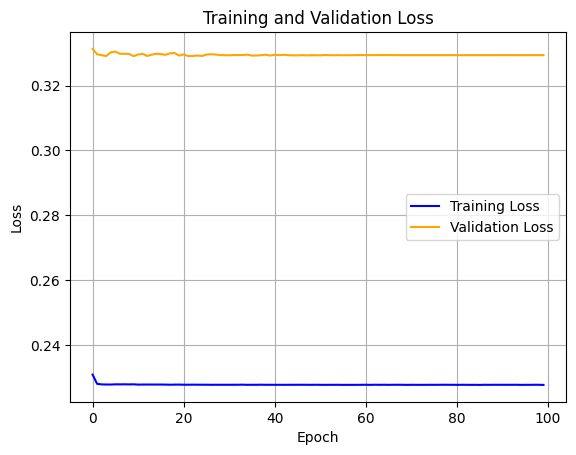

In [ ]:
plot_loss_curves(train_losses, val_losses)

In [ ]:
avg_test_loss = evaluate_model(evaluation_model, baseline_test_dataloader, criterion)

# Evaluate the model's predictions
print(avg_test_loss)

Average Test Loss: 0.3270
0.3270410342914302


In [ ]:
baseline_test_context, baseline_test_measurement, _ = create_custom_dataloader(baseline_test_df, ex_mol_df, 128, device)

In [ ]:
outputs = evaluation_model(torch.tensor(baseline_test_context.to_numpy(dtype=np.float32), device=device))
loss = criterion(outputs,torch.tensor(baseline_test_measurement.to_numpy(dtype=np.float32), device=device))
print(loss)

tensor(0.3107, grad_fn=<MseLossBackward0>)


## Data Inspection with Pandas-Profiling

In [ ]:
baseline_full_data_path = '/content/drive/My Drive/COMS_4995-010_NNDL/Project/Data/full_data.tsv'
baseline_full_data_df = pd.read_csv(baseline_full_data_path, sep='\t')
baseline_full_data_df.head()

,COMPOUND_NAME,SACRI_PERIOD,DOSE_LEVEL,RBC(x10_4/ul),Hb(g/dL),Ht(%),MCV(fL),MCH(pg),MCHC(%),Ret(%),...,Ca(mg/dL),IP(mg/dL),TP(g/dL),RALB(g/dL),A/G,AST(IU/L),ALT(IU/L),LDH(IU/L),GTP(IU/L),stratify_col
0,acetaminophen,8 day,Low,614.0,13.2,38.5,62.6,21.5,34.4,5.8,...,10.6,8.3,6.1,3.5,1.4,69.0,31.0,140.0,1.0,acetaminophen_8 day_Low
1,acetaminophen,8 day,Low,614.0,13.2,38.5,62.6,21.5,34.4,5.8,...,10.6,8.3,6.1,3.5,1.4,69.0,31.0,140.0,1.0,acetaminophen_8 day_Low
2,acetaminophen,8 day,Low,619.0,13.2,39.1,63.2,21.3,33.7,8.1,...,11.0,8.2,6.3,3.9,1.6,56.0,32.0,260.0,1.0,acetaminophen_8 day_Low
3,acetaminophen,8 day,Low,568.0,13.1,38.3,67.4,23.0,34.1,8.1,...,10.8,9.5,5.8,3.5,1.5,50.0,26.0,88.0,2.0,acetaminophen_8 day_Low
4,acetaminophen,8 day,Low,635.0,13.7,40.8,64.2,21.6,33.6,7.4,...,11.3,9.1,5.5,3.4,1.6,51.0,33.0,117.0,1.0,acetaminophen_8 day_Low


In [ ]:
profile = ProfileReport(baseline_full_data_df, title="Baseline Dataset (Real Data Only)")

In [ ]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
baseline_profile.to_file('baseline_data_profile.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]